**Advanced Lane Finding project**

In [1]:
"""
Loading frameworks
"""

import cv2
import glob
from IPython.display import HTML
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np


In [2]:
"""
Importing test image and initializing the data
"""

straight_lines_image = cv2.imread('./test_images/straight_lines1.jpg')
image_size = (straight_lines_image.shape[1], straight_lines_image.shape[0])

print('Image size = {}'.format(image_size))


Image size = (1280, 720)


Some useful functions:

In [3]:
def show_image(image, cmap=None):
    """
    Displays an image
    """
    plt.imshow(image, cmap=cmap)
    plt.show()
    
def read_image(image_name):
    image = cv2.imread(image_name)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

Camera calibration:

In [4]:
def draw_chessboard_corners(image, corners, pattern_size, ret):
    """
    Draws chessboard corners over the image and displays a result
    """
    image = cv2.drawChessboardCorners(image, pattern_size, corners, ret)
    show_image(image)

def calibrate_camera(image_names, pattern_size=(9, 6), show_corners=False):
    """
    Calibrates the camera based on images set with chessboards patterns provided.
    Returns camera calibration matrix and distortion coefficients
    """
    
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
    
    image_size = None
    
    for image_name in image_names:
        image = cv2.imread(image_name)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if image_size is None:
            image_size = gray.shape[::-1]
        ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)
        
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
            if show_corners:
                draw_chessboard_corners(image, corners, pattern_size, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    return mtx, dist

def undistort_image(image, mtx, dist):
    """
    Undistorts an image based on camera calibration matrix and distortion coefficients
    """
    return cv2.undistort(image, mtx, dist, None, mtx)

def show_undistorted_images(image_names, mtx, dist):
    """
    Displays undistorted versions of input images
    """
    for image_name in image_names:
        image = cv2.imread(image_name)
        image = undistort_image(image, mtx, dist)
        show_image(image)
            

Loading camera calibration images and calculating calibration matrix and distortion coefficients

In [5]:
calibration_images = glob.glob('./camera_cal/calibration*.jpg')
calibration_mtx, calibration_dist = calibrate_camera(calibration_images, pattern_size=(9, 6), show_corners=False)


Sobel gradients

In [6]:
def apply_sobel_thresh(gray, orient='x', thresh=(0, 255), kernel_size=3):
    """
    Applies a Sobel threshold with given orientation x or y
    """
    if orient == 'x':
        orient_num = (1, 0)
    elif orient == 'y':
        orient_num = (0, 1)

    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, orient_num[0], orient_num[1], ksize=kernel_size))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

def apply_direction_sobel(gray, kernel_size=15, thresh=(0.7, 1.3)):
    """
    Applies a direction Sobel threshold
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_grad = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(abs_grad)
    binary_output[(abs_grad >= thresh[0]) & (abs_grad <= thresh[1])] = 1
    return binary_output

def apply_magnitude_sobel(gray, kernel_size=3, thresh=(10, 60)):
    """
    Applies a magnitude Sobel threshold
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def blur_image(image, kernel_size=7):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def thresh_gray_image(gray, thresh=(140, 255)):
    ret, gray = cv2.threshold(gray, thresh[0], thresh[1], cv2.THRESH_TOZERO)
    return gray

def combine_magnitude_and_direction(gray, mag_thresh=(10, 60), dir_thresh=(0.7, 1.3)):
    mag_binary = apply_magnitude_sobel(gray, thresh=mag_thresh)
    dir_binary = apply_direction_sobel(gray, thresh=dir_thresh)
    binary_output = np.zeros_like(mag_binary)
    binary_output[(mag_binary == 1) & (dir_binary == 1)] = 1
    return binary_output

def region_of_interest(img, vertices):
    """
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def apply_mask(image):
    """
    Applies a mask for input image of size (1280 x 720)
    """
    left_bottom = [120, 720]
    right_bottom = [1160, 720]
    left_apex = [460, 470]
    right_apex = [820, 470]
    vertices = np.array([[left_bottom, left_apex, right_apex, right_bottom]], dtype=np.int32) #right_subapex, left_subapex, left_subbottom
                         
    return region_of_interest(image, vertices)

In [7]:
def process_image_v1(image, show_plot=False):
    """
    Processes the image by applying Sobel magnitude & direction thresholding, 
    also considering L- and S-channels of HLS image color spaces
    """
    if show_plot:
        show_image(image)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    l_channel = hls[:, :, 1]
    
    thresh = [150, 255]
    s_binary_output = apply_sobel_thresh(s_channel, orient='x', thresh=(40, 100), kernel_size=15)
    if show_plot:
        print('S-channel')
        show_image(s_binary_output, cmap='gray')
        #cv2.imwrite('./v1_test2_schannel.jpg', s_binary_output * 255)
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if show_plot:
        print('Grayscaled')
        show_image(gray, cmap='gray')
        #cv2.imwrite('./v1_test2_grayscale.jpg', gray)
    threshed_m = apply_magnitude_sobel(gray, kernel_size=13, thresh=(20, 100))
    threshed_d = apply_direction_sobel(gray, kernel_size=15, thresh=(0.6, 1.3))
    
    sobelx = apply_sobel_thresh(gray, orient='x', thresh=(20, 100), kernel_size=7)
    if show_plot:
        print('Sobeled x-orient')
        show_image(sobelx, cmap='gray')
        #cv2.imwrite('./v1_test2_sobelx.jpg', sobelx * 255)
    threshed = np.zeros_like(threshed_m)
    threshed[((threshed_m == 1) & (threshed_d == 1)) & (sobelx == 1)] = 1
    if show_plot:
        print('threshed all')
        show_image(threshed, cmap='gray')
        #cv2.imwrite('./v1_test2_threshed.jpg', threshed * 255)
    
    thresh = [155, 255]
    l_binary_output = np.zeros_like(l_channel)
    l_binary_output[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    if show_plot:
        print('L-channel threshed')
        show_image(l_binary_output, cmap='gray')
        #cv2.imwrite('./v1_test2_lchannel.jpg', l_binary_output * 255)

    s_l = np.zeros_like(l_binary_output)
    
    s_l[((threshed == 1) & (l_binary_output == 1)) | (s_binary_output == 1)] = 1
    if show_plot:
        print('All combined')
        show_image(s_l, cmap='gray')
        #cv2.imwrite('./v1_test2_all.jpg', s_l * 255)
        
    return s_l


Testing the image processing

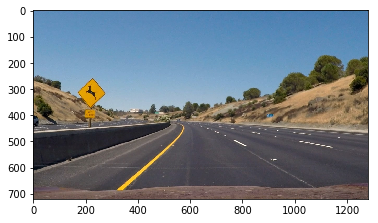

S-channel


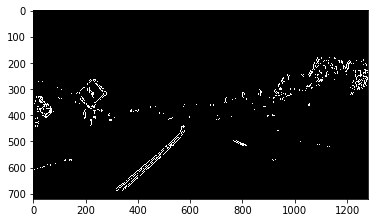

Grayscaled


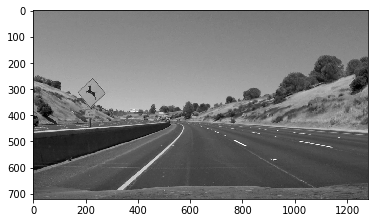

Sobeled x-orient


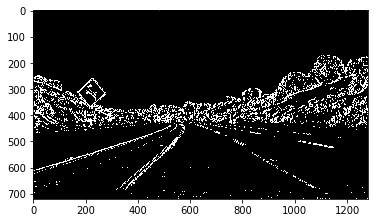

threshed all


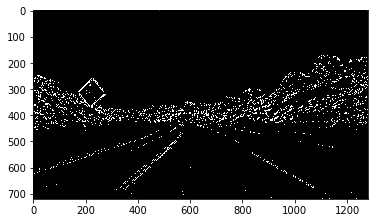

L-channel threshed


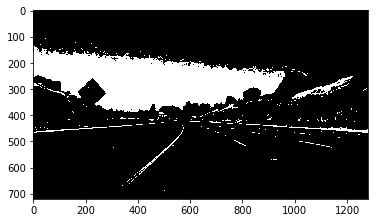

All combined


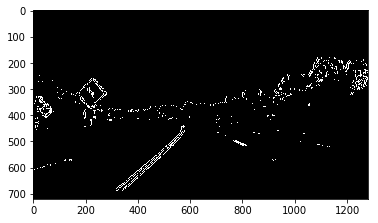

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:
image = read_image('./test_images/test2.jpg')
process_image_v1(image, show_plot=True)


Perspective transformation

In [9]:
def get_perspective_transform(src, dst):
    """
    Calculates a matrix of perspective transformation from src to dst points
    """
    return cv2.getPerspectiveTransform(src, dst)

def warp_perspective(image, M, image_size):
    """
    Returns a warped image after applying a perspective transformation
    """
    return cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)


Calculating perspective matrices

In [10]:
perspective_M = None
perspective_Minv = None

def calculate_perspective(src, dst):
    """
    Calculates perspective constants based on input source and destination points
    """
    global perspective_M
    global perspective_Minv
    
    perspective_M = get_perspective_transform(src, dst)
    perspective_Minv = get_perspective_transform(dst, src)
    

In [11]:
def set_perspective_v1():
    """
    Sets a perspective matrices by providing source and destination points of first model
    """
    src = np.float32([[568, 470], [721, 470], [1048, 682], [275, 682]])
    dst = np.float32([[272, 0], [1037, 0], [1037, 720], [272, 720]])
    calculate_perspective(src, dst)

set_perspective_v1()
    

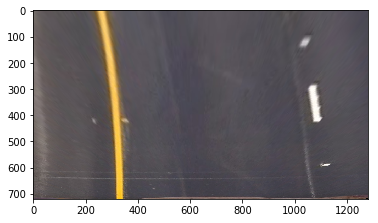

In [12]:
def test_perspective(image, M, image_size):
    image = warp_perspective(image, M, image_size)
    show_image(image)
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # cv2.imwrite('./test2_bird.jpg', image)

image = read_image('./test_images/test2.jpg')
test_perspective(image, perspective_M, image_size)


In [13]:
def sliding_window_search_v1(binary_warped, show_plot=False):
    """
    Finds left and right polynoms describing lines by sliding window search
    """
    histogram = np.sum(binary_warped[3 * binary_warped.shape[0] // 4:,:], axis=0)    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    lmax = np.amax(histogram[:(midpoint)])
    rmax = np.amax(histogram[(midpoint):])
    
    if show_plot:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    nwindows = 120
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    left_lane_inds = []
    right_lane_inds = []

    unfound_left_count = 0
    unfound_right_count = 0
    stop_left = False
    stop_right = False

    for window in range(3 * nwindows // 4):
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if show_plot:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        if stop_left == False:
            left_lane_inds.append(good_left_inds)
        if stop_right == False:
            right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        if len(good_left_inds) < 10:
            unfound_left_count += 1
        else:
            unfound_left_count = 0
        if len(good_right_inds) < 10:
            unfound_right_count += 1
        else:
            unfound_right_count = 0
        
        # if we 'stuck' near the edge for more than 3 windows, 
        # stop searching here to prevent adding possible noisy pixels
        if unfound_left_count > 3 and (win_xleft_low <= 0 or win_xleft_high >= (binary_warped.shape[1] - 1)):
            stop_left = True
        if unfound_right_count > 3 and (win_xright_low <= 0 or win_xright_high >= (binary_warped.shape[1] - 1)):
            stop_right = True

    if len(left_lane_inds) > 0:
        left_lane_inds = np.concatenate(left_lane_inds)
    if len(right_lane_inds) > 0:
        right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    if len(lefty) > 0 and len(leftx) > 1500:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = None
        
    if len(righty) > 0 and len(rightx) > 1500:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = None
        
    if left_fit is not None and right_fit is not None:
        if (left_fit[0] * right_fit[0]) < 0 or left_fit[2] >= right_fit[2]:
            left_fit = None
            right_fit = None

    if show_plot and left_fit is not None and right_fit is not None:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
                
    return left_fit, right_fit
    

def search_points_knowing_polys_v1(binary_warped, left_fit, right_fit, show_plot=False):
    """
    Finds left and right polynoms describing lanes by knowing polynoms from previous frames
    """
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if len(lefty) > 0 and len(leftx) > 1500:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = None
        
    if len(righty) > 0 and len(rightx) > 1500:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = None
    
    last_y = (binary_warped.shape[0] - 1)
    if left_fit is not None:
        # checking if left pixels seem good enough
        first_left_x = left_fit[2]
        last_left_x = left_fit[0] * last_y**2 + left_fit[1] * last_y + left_fit[2]
        if first_left_x > (3*binary_warped.shape[1]//4) or last_left_x < 130:
            left_fit = None
            
    if right_fit is not None:
        # checking that right pixels seem good enough
        first_right_x = right_fit[2]
        last_right_x = right_fit[0] * last_y**2 + right_fit[1] * last_y + right_fit[2]
        if first_right_x < (binary_warped.shape[1]//4) or last_right_x > 1150:
            right_fit = None
    
    if show_plot and left_fit is not None and right_fit is not None:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        
    return left_fit, right_fit


In [14]:
def draw_lines(image, warped, image_size, Minv, left_fitx, right_fitx, ploty):
    """
    Draws road lane on the image by input left and right lanes dots
    """
    
    warp_zero = np.zeros_like(warped, np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    new_warp = cv2.warpPerspective(color_warp, Minv, (image_size[0], image_size[1])) 
    result = cv2.addWeighted(image, 1, new_warp, 0.3, 0)
    return result


In [15]:
class Lane_v1():
    def __init__(self, n):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = None
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        self.previous_best_fit = None
        
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        
        # number of iterations to store pixel values
        self.n = n
        
        # iterations count of line
        self.iterations = 0
        
    def append_x(self, new_x, new_y):
        """
        Appends new x and y pixel data to the lane and re-calculates the best polynom
        """
        self.allx = new_x[:]
        self.ally = new_y[:]
        self.iterations += 1
        
        if self.iterations > self.n:
            self.recent_xfitted = np.delete(self.recent_xfitted, 0, axis=0)
            
        if self.recent_xfitted is None or self.recent_xfitted.shape[0] == 0:
            self.recent_xfitted = np.vstack([new_x])
        else:
            self.recent_xfitted = np.vstack([self.recent_xfitted, new_x])
        
        self.bestx = np.mean(self.recent_xfitted, axis=0)
        
        if len(self.bestx) > 0:
            self.best_fit = np.polyfit(self.ally, self.bestx, 2)
            
        self.detected = False if self.best_fit is None else True
        

In [16]:
left_lane = None
right_lane = None
def init_lanes_v1():
    """
    Initializes lanes objects
    """
    global left_lane
    left_lane = Lane_v1(13)
    global right_lane 
    right_lane = Lane_v1(13)


In [17]:
def get_scale_m_per_px(model):
    """
    Returns scale factors pixels to meters
    """
    if model == 'v1':
        xm_per_px = 3.7 / 800
        ym_per_px = 17 / 720
    elif model == 'v2':
        xm_per_px = 3.7 / 480
        ym_per_px = 14 / 720
    return xm_per_px, ym_per_px


In [18]:
def calculate_curvature_radius(ploty, left_fitx, right_fitx, model='v1'):
    """
    Calculates the curvature radius in meters
    """
    xm_per_px, ym_per_px = get_scale_m_per_px(model)
    
    y_eval = np.max(ploty)
    
    left_fit_cr = np.polyfit(ploty * ym_per_px, left_fitx * xm_per_px, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_px, right_fitx * xm_per_px, 2)
    
    left_radius = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_px + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
    right_radius = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_px + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
    return np.mean([left_radius, right_radius])


In [19]:
def calculate_offset(image_size, left_fit, right_fit, model='v1'):
    xm_per_px, _ = get_scale_m_per_px(model)
    left_last_x = left_fit[0] * (image_size[1] - 1)**2 + left_fit[1] * (image_size[1] - 1) + left_fit[2]
    right_last_x = right_fit[0] * (image_size[1] - 1)**2 + right_fit[1] * (image_size[1] - 1) + right_fit[2]
    mean = np.mean([left_last_x, right_last_x])
    return (mean - (image_size[0] // 2)) * xm_per_px
    

In [20]:
def write_text(image, text, y_coord):
    """
    Writes a text on image
    """
    cv2.putText(image, text, (20, y_coord), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 3)


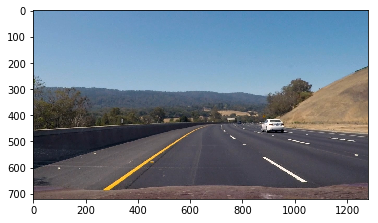

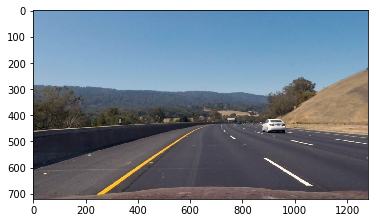

S-channel


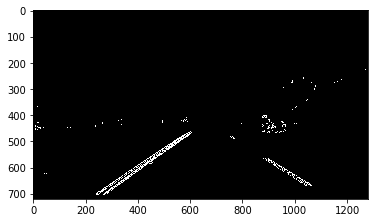

Grayscaled


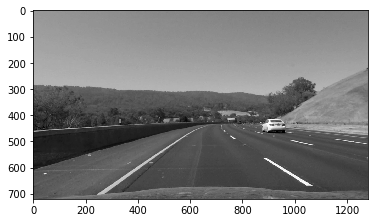

Sobeled x-orient


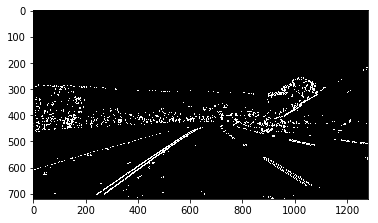

threshed all


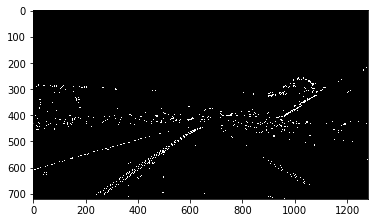

L-channel threshed


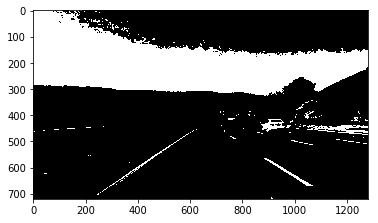

All combined


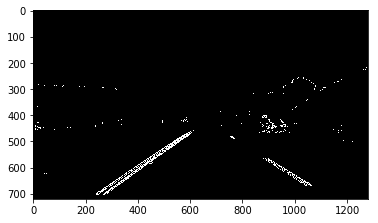

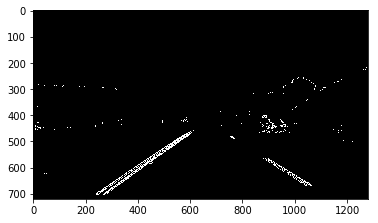

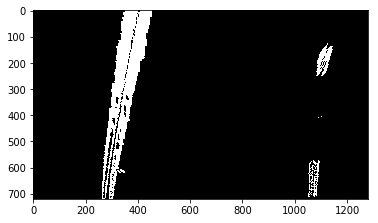

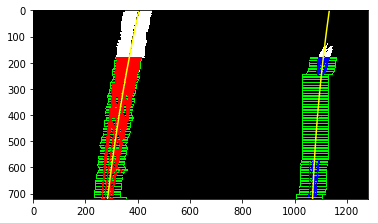

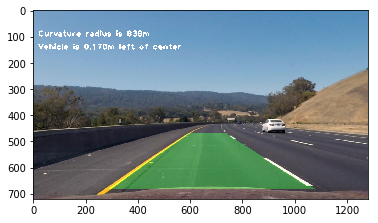

In [21]:
def find_lane_v1(image, image_size, mtx, dist, M, Minv, show_plot=False):
    """
    Undistorts the image, finds and draws a lane on it
    """
    undistorted = undistort_image(image, mtx, dist)
    threshed = process_image_v1(undistorted, show_plot=show_plot)
    if show_plot:
        show_image(threshed, cmap='gray')
    warped = warp_perspective(threshed, M, image_size)
    if show_plot:
        show_image(warped, cmap='gray')
    left_fit, right_fit = sliding_window_search_v1(warped, show_plot)
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0] )
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    image_width = warped.shape[1]
    
    radius = calculate_curvature_radius(ploty, left_fitx, right_fitx)
    offset = calculate_offset((image_width, warped.shape[0]), left_fit, right_fit)
    offset_sign_text = 'left' if offset > 0 else 'right'
    offset_text = 'Vehicle is {:.3f}m '.format(abs(offset)) + offset_sign_text + ' of center'
    
    left_fitx[(left_fitx < 0)] = 0
    left_fitx[(left_fitx >= image_width)] = image_width - 1
    right_fitx[right_fitx < 0] = 0
    right_fitx[right_fitx >= image_width] = image_width - 1
    
    res = draw_lines(undistorted, warped, image_size, Minv, left_fitx, right_fitx, ploty)
    write_text(res, 'Curvature radius is {:.0f}m'.format(radius), 100)
    write_text(res, offset_text, 150)
    
    return res

image = read_image('./test_images/test3.jpg')
show_image(image)
res = find_lane_v1(image, image_size, calibration_mtx, calibration_dist, perspective_M, perspective_Minv, show_plot=True)
show_image(res)
# res = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
# cv2.imwrite('./test3_lanes_rad.jpg', res)


In [22]:
def video_find_lane_v1(image):
    """
    Finds and draws the lane on input video image
    """
    undistorted = undistort_image(image, calibration_mtx, calibration_dist)
    threshed = process_image_v1(undistorted)
    warped = warp_perspective(threshed, perspective_M, image_size)
    
    if left_lane.detected == False or right_lane.detected == False:
        # one of lanes was not detected earlier, so applying sliding window search
        left_fit, right_fit = sliding_window_search_v1(warped, show_plot=False)
    else:
        # applying search using previous polynoms
        left_fit, right_fit = search_points_knowing_polys_v1(warped, left_lane.best_fit, 
                                                          right_lane.best_fit, show_plot=False)
        if left_fit is None or right_fit is None or (left_fit[0] * right_fit[0]) < 0 or left_fit[2] < 0 or right_fit[2] > warped.shape[1] or left_fit[2] >= right_fit[2]:
            # polynoms might be not good, better re-calculate lanes by sliding window
            left_fit, right_fit = sliding_window_search_v1(warped, show_plot=False)
        
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    image_width = warped.shape[1]

    append_left = True
    append_right = True
    
    if left_fit is not None:
        # checking that left lane seems good
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        if left_fitx[len(ploty) - 1] > (image_width // 2 - 200) or left_fitx[len(ploty) - 1] < 100:
            append_left = False
    else:
        append_left = False
        
    if right_fit is not None:
        # checking that right lane seems good
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        if right_fitx[len(ploty) - 1] < (image_width // 2 + 200) or right_fitx[len(ploty) - 1] > (image_width - 100):
            append_right = False
    else:
        append_right = False
        
    if left_fit is not None and right_fit is not None:
        # checking both lanes together
        if left_fit[0] * right_fit[0] < 0:
            append_left = False
            append_right = False
        
    if append_left:
        left_lane.append_x(left_fitx, ploty)
    if append_right:
        right_lane.append_x(right_fitx, ploty)
       
    if left_lane.best_fit is not None and right_lane.best_fit is not None:
        # lanes found, drawing lines
        left_fitx = left_lane.best_fit[0] * ploty**2 + left_lane.best_fit[1] * ploty + left_lane.best_fit[2]
        right_fitx = right_lane.best_fit[0] * ploty**2 + right_lane.best_fit[1] * ploty + right_lane.best_fit[2]
        
        radius = calculate_curvature_radius(ploty, left_fitx, right_fitx)
        offset = calculate_offset((image_width, warped.shape[0]), left_lane.best_fit, right_lane.best_fit)
        offset_sign_text = 'left' if offset > 0 else 'right'
        offset_text = 'Vehicle is {:.3f}m '.format(abs(offset)) + offset_sign_text + ' of center'
        
        left_fitx[(left_fitx < 0)] = 0
        left_fitx[(left_fitx >= image_width)] = image_width - 1
        right_fitx[right_fitx < 0] = 0
        right_fitx[right_fitx >= image_width] = image_width - 1
        
        res = draw_lines(undistorted, warped, image_size, perspective_Minv, left_fitx, right_fitx, ploty)
        write_text(res, 'Curvature radius is {:.0f}m'.format(radius), 100)
        write_text(res, offset_text, 150)
        
        # show_image(res)
        return res
    
    return undistorted


In [23]:
def process_video_v1(video_clip_name, output_clip_name):
    """
    Processes the video clip and produces output clip with lanes on it.
    """
    init_lanes_v1()
    video_clip = VideoFileClip(video_clip_name)
    output_clip = video_clip.fl_image(video_find_lane_v1)
    %time output_clip.write_videofile(output_clip_name, audio=False)
    

Processing all videos

In [24]:
process_video_v1('./project_video.mp4', './output_videos/project_video_v1.mp4')


[MoviePy] >>>> Building video ./output_videos/project_video_v1.mp4
[MoviePy] Writing video ./output_videos/project_video_v1.mp4


100%|█████████▉| 1260/1261 [07:34<00:00,  2.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_v1.mp4 

CPU times: user 8min, sys: 31.7 s, total: 8min 31s
Wall time: 7min 35s


In [25]:
process_video_v1('./challenge_video.mp4', './output_videos/challenge_video_output_v1.mp4')


[MoviePy] >>>> Building video ./output_videos/challenge_video_output_v1.mp4
[MoviePy] Writing video ./output_videos/challenge_video_output_v1.mp4


100%|██████████| 485/485 [02:58<00:00,  2.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/challenge_video_output_v1.mp4 

CPU times: user 3min 7s, sys: 12.6 s, total: 3min 20s
Wall time: 2min 59s


In [26]:
process_video_v1('./harder_challenge_video.mp4', './output_videos/harder_challenge_video_output_v1.mp4')


[MoviePy] >>>> Building video ./output_videos/harder_challenge_video_output_v1.mp4
[MoviePy] Writing video ./output_videos/harder_challenge_video_output_v1.mp4


100%|█████████▉| 1199/1200 [07:28<00:00,  2.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/harder_challenge_video_output_v1.mp4 

CPU times: user 7min 52s, sys: 29.3 s, total: 8min 21s
Wall time: 7min 29s


**Model v2**
An attempt to create a model better fitting for the 3rd video and turns specifically

In [27]:
def process_image_v2(image, show_plot=False, show_only_final=False):
    """
    Processes the image by applying Sobel magnitude & direction thresholding, 
    also considering L- and S-channels of HLS image color spaces
    """
    if show_plot:
        show_image(image)
    blurred = blur_image(image, kernel_size=9)
    hls = cv2.cvtColor(blurred, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    l_channel = hls[:, :, 1]
    
    thresh = [150, 255]
    s_binary_output = apply_sobel_thresh(s_channel, orient='x', thresh=(40, 100), kernel_size=15)
    if show_plot:
        print('S-channel')
        show_image(s_binary_output, cmap='gray')
    
    gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
    gray = image[:, :, 2]
    if show_plot:
        print('Grayscale')
        show_image(gray, cmap='gray')
    
    sobelx = apply_sobel_thresh(gray, orient='x', thresh=(40, 100), kernel_size=13)
    sobely = apply_sobel_thresh(gray, orient='y', thresh=(40, 100), kernel_size=13)
    sobel_a = np.zeros_like(l_channel)
    sobel_a[(sobelx == 1) & (sobely == 1)] = 1
    if show_plot:
        print('Sobel x- and y- oriented')
        show_image(sobel_a, cmap='gray')
    thresh = [155, 255]
    l_binary_output = np.zeros_like(l_channel)
    l_binary_output[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    if show_plot:
        print('L-channel')
        show_image(l_binary_output, cmap='gray')

    luv = cv2.cvtColor(image, cv2.COLOR_RGB2Luv)
    v_channel = luv[:, :, 2]
    vx_binary_output = apply_sobel_thresh(v_channel, orient='x', thresh=(20, 100), kernel_size=15)
    vy_binary_output = apply_sobel_thresh(v_channel, orient='y', thresh=(40, 100), kernel_size=15)
    v_binary_output = np.zeros_like(vx_binary_output)
    v_binary_output[(vx_binary_output == 1) & (vy_binary_output == 1)] = 1
    if show_plot:
        print('V-channel for Luv space')
        show_image(v_binary_output, cmap='gray')
    
    s_l = np.zeros_like(l_binary_output)
    s_l[((sobel_a == 1) & (l_binary_output == 1)) | (v_binary_output == 1)] = 1
    if show_plot or show_only_final:
        print('all combined')
        show_image(s_l, cmap='gray')
        #cv2.imwrite('./v2_hard1_all.jpg', s_l * 255)
                
    return s_l


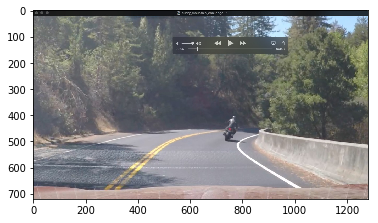

S-channel


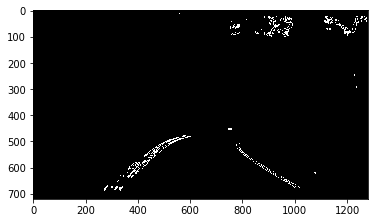

Grayscale


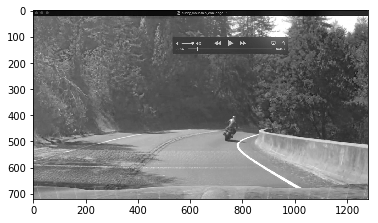

Sobel x- and y- oriented


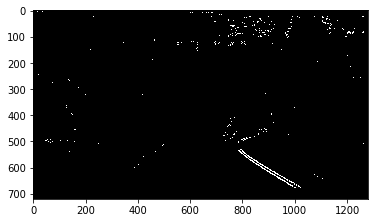

L-channel


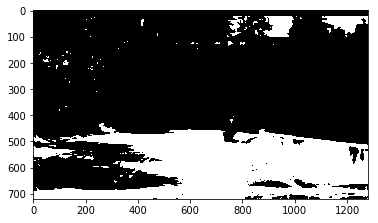

V-channel for Luv space


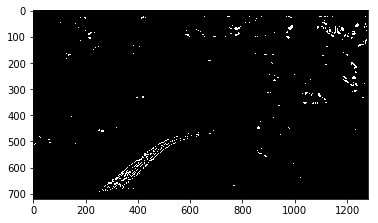

all combined


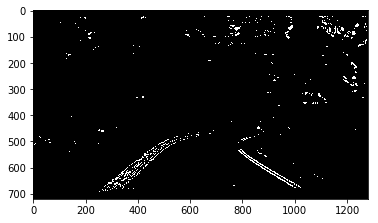

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 1, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [28]:
image = read_image('./test_images/hard1.jpg')
process_image_v2(image, show_plot=True)

In [29]:
def set_perspective_v2():
    """
    Sets a perspective matrices by providing source and destination points of first model
    """
    src = np.float32([[568, 470], [721, 470], [1048, 682], [275, 682]])
    dst = np.float32([[400, 0], [880, 0], [880, 720], [400, 720]])
    calculate_perspective(src, dst)

set_perspective_v2()

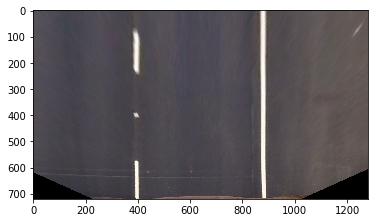

In [30]:
image = read_image('./test_images/straight_lines2.jpg')
test_perspective(image, perspective_M, image_size)

In [31]:
def sliding_window_search_v2(binary_warped, show_plot=False):
    """
    Finds left and right polynoms describing lines by sliding window search (model v2)
    """
    histogram = np.sum(binary_warped[4 * binary_warped.shape[0] // 5:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint-100])
    rightx_base = np.argmax(histogram[midpoint+100:]) + midpoint + 100
    
    if np.mean(histogram) < 1.0:
        return None, None
    
    if show_plot:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    nwindows = 80
    window_height = np.int(binary_warped.shape[0] / nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 90
    minpix = 20
    minaddpix = 15

    left_lane_inds = []
    right_lane_inds = []

    unfound_left_count = 0
    unfound_right_count = 0
    first_found_left = nwindows
    first_found_right = nwindows
    stop_left = False
    stop_right = False
    
    left_started = False
    right_started = False
    
    # Step through the windows one by one
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if show_plot:
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high,win_y_high), (0, 255, 0), 2) 
            cv2.rectangle(out_img, (win_xright_low, win_y_low),(win_xright_high,win_y_high), (0, 255, 0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        if stop_left == False and len(good_left_inds) > minaddpix:
            if window < first_found_left:
                first_found_left = window
            left_lane_inds.append(good_left_inds)
            unfound_left_count = 0
            left_started = True
        else:
            unfound_left_count += 1
            
        if stop_right == False and len(good_right_inds) > minaddpix:
            if window < first_found_right:
                first_found_right = window
            right_lane_inds.append(good_right_inds)
            unfound_right_count = 0
            right_started = True
        else:
            unfound_right_count += 1

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                    
        if unfound_left_count > 5 and (win_xleft_low <= 0 or win_xleft_high >= (binary_warped.shape[1] - 1)):
            stop_left = True
        if unfound_right_count > 5 and (win_xright_low <= 0 or win_xright_high >= (binary_warped.shape[1] - 1)):
            stop_right = True

    if len(left_lane_inds) > 0:
        left_lane_inds = np.concatenate(left_lane_inds)
    if len(right_lane_inds) > 0:
        right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    if len(lefty) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = None
        
    if len(righty) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = None

    image_width = binary_warped.shape[1]
    last_y = binary_warped.shape[0] - 1
    
    if left_fit is not None:
        last_left_x = left_fit[0] * last_y**2 + left_fit[1] * last_y + left_fit[2]
        if last_left_x > image_width // 2 or last_left_x < 200:
            left_fit = None
        elif left_fit[2] < (-4 * image_width) or left_fit[2] > 4 * image_width:
            left_fit = None
        elif left_fit[2] < 0 and left_fit[0] > 0:
            left_fit = None
            
    if right_fit is not None:
        last_right_x = right_fit[0] * last_y**2 + right_fit[1] * last_y + right_fit[2]
        if last_right_x < image_width // 2 or last_right_x > image_width - 200:
            right_fit = None
        elif right_fit[2] < (-4 * image_width) or right_fit[2] > 4 * image_width:
            right_fit = None
        elif right_fit[2] > image_width and right_fit[0] < 0:
            right_fit = None

    if len(left_lane_inds) > 0 and len(right_lane_inds) > 0:
        if len(np.intersect1d(left_lane_inds, right_lane_inds) > 300):
            if len(left_lane_inds) >= len(right_lane_inds):
                right_fit = None
            else:
                left_fit = None

    if show_plot:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        if left_fit is not None:
            left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        if right_fit is not None:
            right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        plt.imshow(out_img)
        if left_fit is not None:
            plt.plot(left_fitx, ploty, color='yellow')
        if right_fit is not None:
            plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
             
    return left_fit, right_fit


def search_points_knowing_polys_v2(binary_warped, left_fit, right_fit, show_plot=False):
    """
    Finds left and right polynoms describing lanes by knowing polynoms from previous frames (model v2)
    """
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if len(lefty) > 0 and len(leftx) > 200:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = None
        
    if len(righty) > 0 and len(rightx) > 200:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = None
    
    last_y = (binary_warped.shape[0] - 1)
    image_width = binary_warped.shape[1]

    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    if left_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        first_left_x = left_fit[2]
        last_left_x = left_fit[0] * last_y**2 + left_fit[1] * last_y + left_fit[2]
        if first_left_x > (3*binary_warped.shape[1]//4) or first_left_x < (-2 * image_width) or last_left_x < 130:
            left_fit = None
            
    if right_fit is not None:
        first_right_x = right_fit[2]
        last_right_x = right_fit[0] * last_y**2 + right_fit[1] * last_y + right_fit[2]
        if first_right_x < (binary_warped.shape[1]//4) or first_right_x > (2 * image_width) or last_right_x > 1150:
            right_fit = None
    
    if left_fit is not None and right_fit is not None:
         if left_fit[0] * right_fit[0] < 0 or left_fit[2] >= right_fit[2]:
            left_fit = None
            right_fit = None
    
    if show_plot:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        if left_fit is not None:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))

        if right_fit is not None:
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        if left_fit is not None:
            plt.plot(left_fitx, ploty, color='yellow')
        if right_fit is not None:
            plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        
    return left_fit, right_fit


In [32]:
def find_lane_v2(image, image_size, mtx, dist, M, Minv, show_plot=False):
    """
    Undistorts the image, finds and draws a lane on it (model v2)
    """
    undistorted = undistort_image(image, mtx, dist)
    threshed = process_image_v2(undistorted, show_plot=show_plot)
    if show_plot:
        show_image(threshed, cmap='gray')
    warped = warp_perspective(threshed, M, image_size)
    if show_plot:
        show_image(warped, cmap='gray')
    left_fit, right_fit = sliding_window_search_v2(warped, show_plot)
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0] )
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    image_width = warped.shape[1]
    radius = calculate_curvature_radius(ploty, left_fitx, right_fitx, model='v2')
    offset = calculate_offset((image_width, warped.shape[0]), left_fit, right_fit, model='v2')
    offset_sign_text = 'left' if offset > 0 else 'right'
    offset_text = 'Vehicle is {:.3f}m '.format(abs(offset)) + offset_sign_text + ' of center'
    
    left_fitx[(left_fitx < 0)] = 0
    left_fitx[(left_fitx >= image_width)] = image_width - 1
    right_fitx[right_fitx < 0] = 0
    right_fitx[right_fitx >= image_width] = image_width - 1
    res = draw_lines(undistorted, warped, image_size, Minv, left_fitx, right_fitx, ploty)
    
    write_text(res, 'Curvature radius is {:.0f}m'.format(radius), 100)
    write_text(res, offset_text, 150)
    
    return res

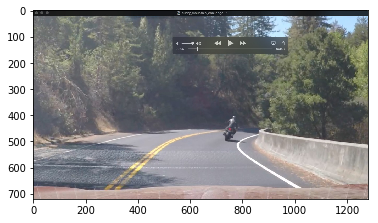

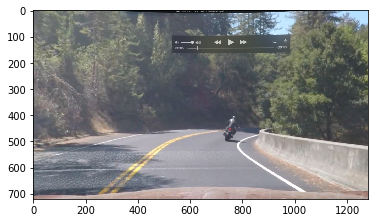

S-channel


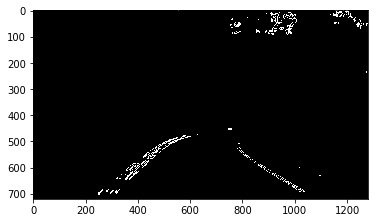

Grayscale


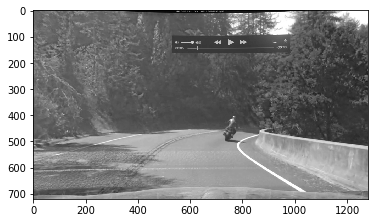

Sobel x- and y- oriented


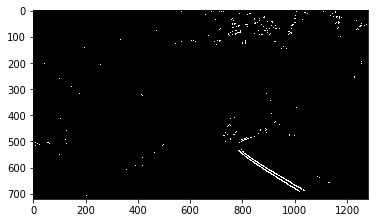

L-channel


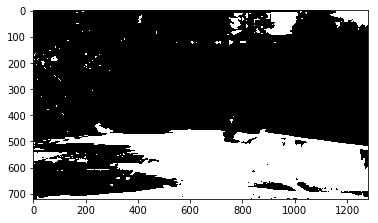

V-channel for Luv space


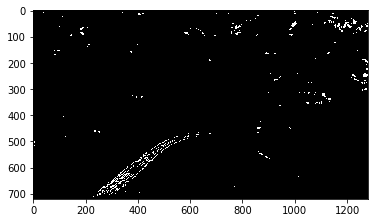

all combined


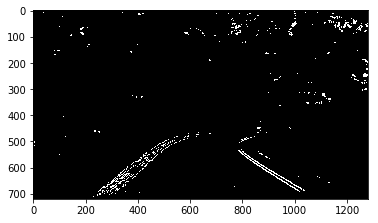

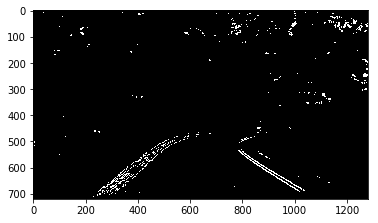

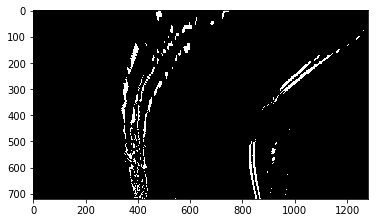

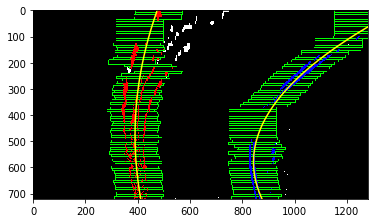

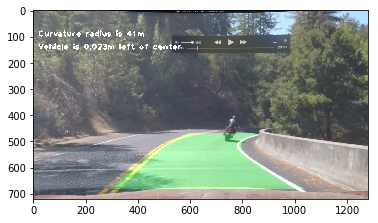

True

In [33]:
image = read_image('./test_images/hard1.jpg')
show_image(image)
res = find_lane_v2(image, image_size, calibration_mtx, calibration_dist, perspective_M, perspective_Minv, show_plot=True)
show_image(res)
res = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
cv2.imwrite('./v2_hard1_lanes.jpg', res)


In [34]:
class Lane_v2():
    def __init__(self, n):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = None
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        
        # number of iterations to store pixel values
        self.n = n
        
        # iterations count of line
        self.iterations = 0
        
    def build_best_fit(self, x, y, deleted_data):
        """
        Builds a best fit polynom based on x and y. If it is not good, it is reverted to the previous one
        """
        self.best_fit = np.polyfit(y, x, 2)
        if self.best_fit[2] < (-4 * 1280) or self.best_fit[2] > (4 * 1280):
            self.remove_old_data()
            self.append_new_data(deleted_data, self.ally)
        self.detected = False if self.best_fit is None else True
        
    def append_new_data(self, new_x, new_y):
        """
        Appends a new pixel data and builds a best polynom based on it
        """
        if self.ally is None:
            self.ally = new_y[:]
        self.iterations += 1
        
        deleted_data = None
        if self.recent_xfitted is not None and self.recent_xfitted.shape[0] > self.n:
            deleted_data = self.recent_xfitted[0]
            self.recent_xfitted = np.delete(self.recent_xfitted, 0, axis=0)
            
        if self.recent_xfitted is None or self.recent_xfitted.shape[0] == 0:
            self.recent_xfitted = np.vstack([new_x])
        else:
            self.recent_xfitted = np.vstack([self.recent_xfitted, new_x])
        
        self.bestx = np.mean(self.recent_xfitted, axis=0)
        self.build_best_fit(self.bestx, self.ally, deleted_data)
            
    def remove_old_data(self):
        """
        Removes an oldest data
        """
        if self.iterations == 0:
            return
        if self.recent_xfitted is not None and self.recent_xfitted.shape[0] > 1 and self.iterations > self.n:
            self.recent_xfitted = np.delete(self.recent_xfitted, 0, axis=0)
        self.bestx = np.mean(self.recent_xfitted, axis=0)
        self.build_best_fit(self.bestx, self.ally)
        

In [35]:
def init_lanes_v2():
    """
    Initializes lanes for model v2
    """
    global left_lane
    left_lane = Lane_v2(15)
    global right_lane 
    right_lane = Lane_v2(15)

In [36]:
def video_find_lane_v2(image):
    """
    Finds and draws the lane on input video image (model v2)
    """
    undistorted = undistort_image(image, calibration_mtx, calibration_dist)
    threshed = process_image_v2(undistorted)
    warped = warp_perspective(threshed, perspective_M, image_size)
    
    if left_lane.detected == False or right_lane.detected == False:
        left_fit, right_fit = sliding_window_search_v2(warped, show_plot=False)
    else:
        left_fit, right_fit = search_points_knowing_polys_v2(warped, left_lane.best_fit, 
                                                         right_lane.best_fit, show_plot=False)
        if left_fit is None or right_fit is None or (left_fit[0] * right_fit[0]) < 0 or left_fit[2] < 0 or right_fit[2] > warped.shape[1] or left_fit[2] >= right_fit[2]:
            left_fit, right_fit = sliding_window_search_v2(warped, show_plot=False)
        
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    image_width = warped.shape[1]

    append_left = True
    append_right = True
    
    if left_fit is not None:
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        if left_lane.best_fit is not None:
            left_best_fitx = left_lane.best_fit[0] * ploty**2 + left_lane.best_fit[1] * ploty + left_lane.best_fit[2]
            if abs(left_fitx[len(ploty) - 1] - left_best_fitx[len(ploty) - 1]) > 100:
                append_left = False
    else:
        append_left = False
        
    if right_fit is not None:
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        if right_lane.best_fit is not None:
            right_best_fitx = right_lane.best_fit[0] * ploty**2 + right_lane.best_fit[1] * ploty + right_lane.best_fit[2]
            if abs(right_fitx[len(ploty) - 1] - right_best_fitx[len(ploty) - 1]) > 100:
                append_right = False
    else:
        append_right = False
                
    if append_left == True:
        left_lane.append_new_data(left_fitx, ploty)
    if append_right == True:
        right_lane.append_new_data(right_fitx, ploty)
    
    if left_lane.best_fit is not None and right_lane.best_fit is not None:
        left_fitx = left_lane.best_fit[0] * ploty**2 + left_lane.best_fit[1] * ploty + left_lane.best_fit[2]
        right_fitx = right_lane.best_fit[0] * ploty**2 + right_lane.best_fit[1] * ploty + right_lane.best_fit[2]
        
        radius = calculate_curvature_radius(ploty, left_fitx, right_fitx, model='v2')
        offset = calculate_offset((image_width, warped.shape[0]), left_lane.best_fit, right_lane.best_fit, model='v2')
        offset_sign_text = 'left' if offset > 0 else 'right'
        offset_text = 'Vehicle is {:.3f}m '.format(abs(offset)) + offset_sign_text + ' of center'
        
        left_fitx[(left_fitx > warped.shape[1] - 1)] = warped.shape[1] - 1
        left_fitx[(left_fitx < 0)] = 0
        right_fitx[(right_fitx > warped.shape[1] - 1)] = warped.shape[1] - 1
        right_fitx[(right_fitx < 0)] = 0
        
        indices = np.zeros_like(right_fitx)
        indices[right_fitx < left_fitx] = 1
        if abs(left_fitx[0]) > abs(right_fitx[0]):
            right_fitx[indices == 1] = left_fitx[indices == 1]
        else:
            left_fitx[indices == 1] = right_fitx[indices == 1]
            
        res = draw_lines(undistorted, warped, image_size, perspective_Minv, left_fitx, right_fitx, ploty)
        write_text(res, 'Curvature radius is {:.0f}m'.format(radius), 100)
        write_text(res, offset_text, 150)

        # show_image(res)
        return res
    
    return undistorted


In [37]:
def process_video_v2(video_clip_name, output_clip_name):
    """
    Processes the video clip and produces output clip with lanes on it (model v2). 
    """
    init_lanes_v2()
    video_clip = VideoFileClip(video_clip_name)
    output_clip = video_clip.fl_image(video_find_lane_v2)
    %time output_clip.write_videofile(output_clip_name, audio=False)

In [38]:
process_video_v2('./harder_challenge_video.mp4', './output_videos/harder_challenge_video_output_v2.mp4')

[MoviePy] >>>> Building video ./output_videos/harder_challenge_video_output_v2.mp4
[MoviePy] Writing video ./output_videos/harder_challenge_video_output_v2.mp4


100%|█████████▉| 1199/1200 [06:23<00:00,  3.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/harder_challenge_video_output_v2.mp4 

CPU times: user 7min 44s, sys: 4.02 s, total: 7min 48s
Wall time: 6min 24s
